In [1]:
import random
import torch.nn as nn
import pandas as pd
import imageio
import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline


# training data
SEED = 3047
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

x = torch.FloatTensor(20, 1).uniform_(-2, 2)
x = x.tolist()  # tensor to list
x.sort()  # sort from small to large
x = torch.tensor(x)  # list to tensor
y = torch.sin(2*x)+0.25*torch.randn(x.size())

x2 = torch.FloatTensor(200, 1).uniform_(-2, 2)
x2 = x2.tolist()
x2.sort()
x2 = torch.tensor(x2)
target = torch.sin(2*x2)

# validation data
SEED = 3047
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

validx = torch.FloatTensor(20, 1).uniform_(-2+0.05, 2+0.05)
validx = validx.tolist()  
validx.sort()  
validx = torch.tensor(validx)  
target1 = torch.sin(2*validx)
y1 = torch.sin(2*validx)+0.25*torch.randn(validx.size())

# test data
SEED = 3047
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

testx = torch.FloatTensor(200, 1).uniform_(-2, 2+0.05)
testx = testx.tolist()
testx.sort()
testx = torch.tensor(testx)
target2 = torch.sin(2*testx)
y2 = torch.sin(2*testx) + 0.25*torch.randn(testx.size())

# sp=-2 #single point x=-2
# sp=torch.tensor(sp)
# print(type(sp))

<class 'torch.Tensor'>


In [2]:
class custom(nn.Module):  #  the activation function defined -- threshold + noise injected
    def __init__(self, width):
        super().__init__()
        self.sigma = nn.Parameter(torch.rand(1)) # learnable parameter --  sigma

    def forward(self, input):
        temp = 0.5-torch.erf((-input)/self.sigma/1.4142136)/2
        return temp


class Net(torch.nn.Module):  
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  
        self.custom1 = custom(n_hidden1)  # custom activation function layer
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # output layer

    def forward(self, x):

        x = self.hidden1(x)
        x = self.custom1(x)
        x = self.predict(x)  
        return x

In [3]:
#CPU
net = Net(n_feature=1, n_hidden1=21, n_output=1)    

device = torch.device('cpu')

weight_params=[]
sigma_params=[]
for pname,p in net.named_parameters():
    if any([pname.endswith(k) for k in ['sigma']]):
        sigma_params+=[p]
    else:
        weight_params+=[p]

#setting different learning rate for different parameters
optimizer =torch.optim.AdamW([{'params':weight_params},
                              {'params':sigma_params,'lr':0.003,'betas':(0.96,0.96)}],lr=0.01,betas=(0.96,0.96))

loss_func = torch.nn.MSELoss().to(device)  
x=x.to(device)
y=y.to(device)   

0.031935968


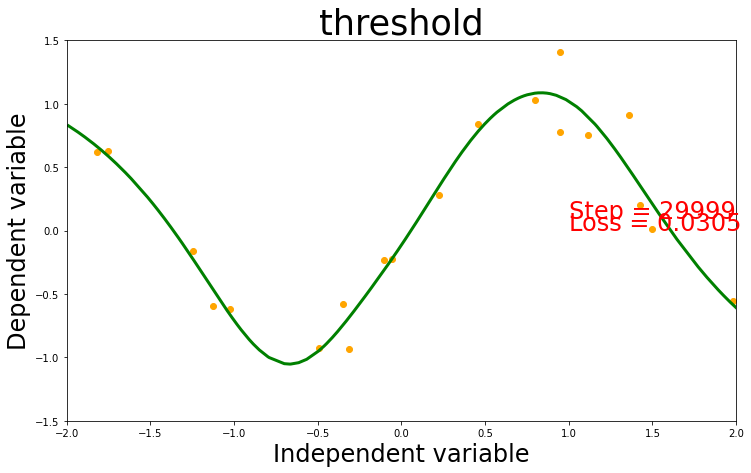

In [4]:
my_images = []
fig, ax = plt.subplots(figsize=(12, 7)) 

epoch = 30000

z=net.custom1.sigma 
nn.init.constant_(z,12.5)

para0 = torch.zeros(epoch)  # para0 -- record the loss value of each epoch during training process
para1 = torch.zeros(epoch)  # para1 -- record the loss value of each epoch during validation process

para2=torch.tensor([]) # record the learnable parameter -- sigma
para3=torch.tensor([])

paraweight1=torch.tensor([])
parabias1=torch.tensor([])

paraweight2=torch.tensor([])
parabias2=torch.tensor([])

for t in range(epoch):  

    prediction = net(x)  
    loss = loss_func(prediction, y)     

    para0[t] = loss.data  

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)         
    optimizer.step()       

    
     if t%1==0:
        for name, param in net.named_parameters(): 
            if param.requires_grad:
                if name=='custom1.sigma': 
                    temppara2=param.data  
                    para2=torch.cat([para2,temppara2],dim=0) 
#                 if name=='custom1.theta': 
#                     temppara3=param.data  
#                     para3=torch.cat([para3,temppara3],dim=0) 
                if name=='hidden1.weight': 
                    temppara4=param.T.data  
                    paraweight1=torch.cat([paraweight1,temppara4],dim=0) 
                if name=='hidden1.bias': 
                    temppara5=param.data  
                    parabias1=torch.cat([parabias1,temppara5],dim=0) 
                if name=='predict.weight': 
                    temppara6=param.T.data  
                    paraweight2=torch.cat([paraweight2,temppara6],dim=0) 
                if name=='predict.bias': 
                    temppara7=param.data  
                    parabias2=torch.cat([parabias2,temppara7],dim=0) 


                    
    if t % 100 == 99:  # validate the model after 100 training epoch
        validy = net(validx)  
        lossV = loss_func(validy,y1)
        para1[t] = lossV.data


# plot figure
plt.cla() 
ax.set_title('threshold', fontsize=35)
ax.set_xlabel('Independent variable', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
ax.set_xlim(-2, 2)
ax.set_ylim(-1.5, 1.5)
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")

testy = net(testx)  
lossT = loss_func(testy, target2)
ax.plot(testx.data.numpy(), testy.data.numpy(), 'g-', lw=3)
ax.text(1.0, 0.1, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
ax.text(1.0, 0, 'Loss = %.4f' % lossV.data.numpy(), fontdict={'size': 24, 'color':  'red'})  

print(lossT.detach().numpy())

C:\Users\HP\AppData\Local\Temp/ipykernel_1376/1485848807.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  k=torch.range(1,epoch)


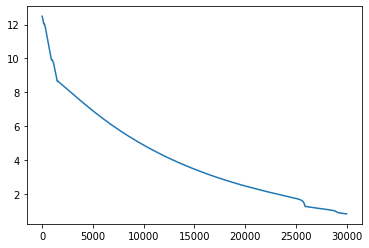

In [5]:
k=torch.range(1,epoch)
plt.plot(k, para2)
plt.show()

C:\Users\HP\AppData\Local\Temp/ipykernel_1376/2370958065.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  k=torch.range(1,epoch)


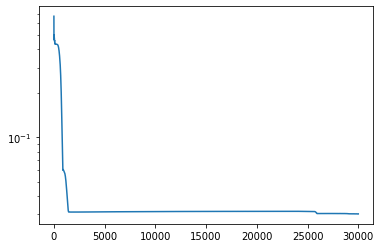

In [6]:
k=torch.range(1,epoch)
plt.plot(k, para0)
plt.yscale('log')
plt.show()

In [7]:
for name,param in net.named_parameters():
    print(name,param) 

hidden1.weight Parameter containing:
tensor([[ 0.0138],
        [-0.0177],
        [ 0.0180],
        [-0.6898],
        [-0.6749],
        [-0.0162],
        [ 0.7767],
        [ 0.0211],
        [-0.7291],
        [ 2.7522],
        [ 0.0048],
        [ 0.0133],
        [ 0.6965],
        [-0.6745],
        [ 0.0044],
        [-2.2686],
        [ 0.6657],
        [-0.6656],
        [ 0.6614],
        [-0.0208],
        [-2.4619]], requires_grad=True)
hidden1.bias Parameter containing:
tensor([ 0.0246, -0.0696, -0.0043,  0.1061,  0.0530, -0.0880, -0.3189, -0.0227,
         0.2145, -0.5042,  0.1444,  0.0257, -0.1275,  0.0516,  0.1513,  1.5520,
        -0.0145,  0.0134,  0.0067, -0.0453, -0.9596], requires_grad=True)
custom1.sigma Parameter containing:
tensor([0.8104], requires_grad=True)
predict.weight Parameter containing:
tensor([[ 0.2636, -0.1045,  0.2647,  1.5497,  1.5696, -0.0920, -1.3586,  0.2684,
          1.4835,  2.9654,  0.2998,  0.2460, -1.2897,  1.5199,  0.2844, -3.2272,
  

In [8]:
print(lossV.detach().numpy())
print(lossT.detach().numpy())

0.030523866
0.031935968


In [9]:
frame1 = pd.DataFrame(para0.data.numpy())
frame1.to_csv('E:/jupyterpath/D1/均布/threlt.csv', index=False)
frame1 = pd.DataFrame(para1.data.numpy()) 
frame1.to_csv('E:/jupyterpath/D1/均布/threlv.csv', index=False)
frame1 = pd.DataFrame(para2.data.numpy()) 
frame1.to_csv('E:/jupyterpath/D1/均布/sigma.csv', index=False)

frame1 = pd.DataFrame(x.data.numpy()) 
frame1.to_csv('E:/jupyterpath/D1/均布/x.csv', index=False)
frame1 = pd.DataFrame(y.data.numpy())
frame1.to_csv('E:/jupyterpath/D1/均布/y.csv', index=False)

frame1 = pd.DataFrame(x2.data.numpy()) 
frame1.to_csv('E:/jupyterpath/D1/均布/x2.csv', index=False)
frame1 = pd.DataFrame(target.data.numpy())
frame1.to_csv('E:/jupyterpath/D1/均布/target.csv', index=False)

frame1 = pd.DataFrame(testx.data.numpy()) 
frame1.to_csv('E:/jupyterpath/D1/均布/testx.csv', index=False)
frame1 = pd.DataFrame(testy.data.numpy())
frame1.to_csv('E:/jupyterpath/D1/均布/testy.csv', index=False)